Enough has changed that I need to redo the model. 
New line fluxes?
New dem.
Cut off of G430L
Can I get any flux out of the NUV?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
nuvpath = '/home/david/work/muscles/SEDs/trappist-1/test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g230l_v6_component-spec.ecsv'
data = Table.read(nuvpath)
nw, nf, ne = data['WAVELENGTH'], data['FLUX'], data['ERROR']

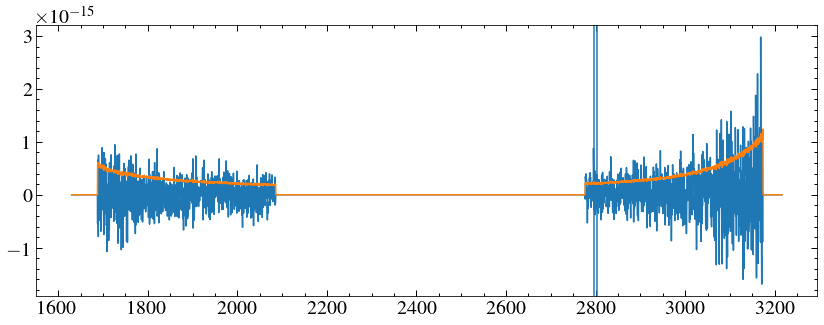

In [3]:
mglines = [2795.523, 2802.697]
plt.plot(nw, nf)
#plt.xlim(2780, 2820)
[plt.axvline(line) for line in mglines]
plt.plot(nw, ne)

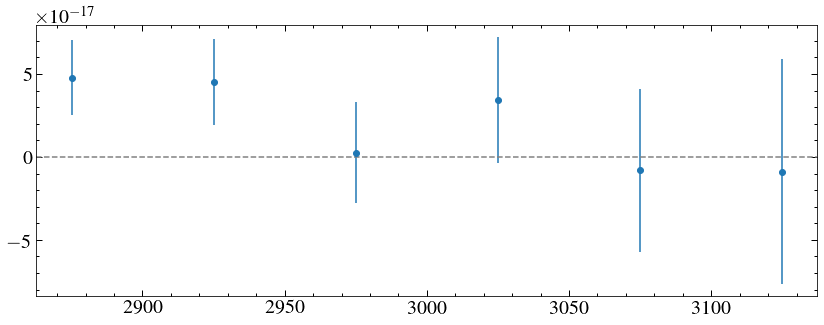

In [4]:
#mask = (nw > 1700) & (nw <2100) | (nw >2850) & (nw < 3150)
mask =  (nw >2850) & (nw < 3150)
nw1, ne1, nf1 = nw[mask], ne[mask], nf[mask]
binres = 50
binning= int((len(nw1)*binres)/(nw1[-1] - nw1[0])) 



wave_binned = np.mean(nw1[:(len(nw1)//binning)*binning].reshape(-1,binning),axis=1)
flux_binned = np.mean(nf1[:(len(nf1)//binning)*binning].reshape(-1,binning),axis=1)
error_binned = np.sqrt(np.nansum((ne1[:(len(nf1)//binning)*binning].reshape(-1,binning))**2,axis=1))/binning
plt.errorbar(wave_binned, flux_binned, yerr= error_binned, marker='o', ls='none', label='MM SED, {}\,\AA\ bins'.format(binres))
plt.axhline(0, ls='--', c='0.5')

No flux there. So just G430L and DEM?

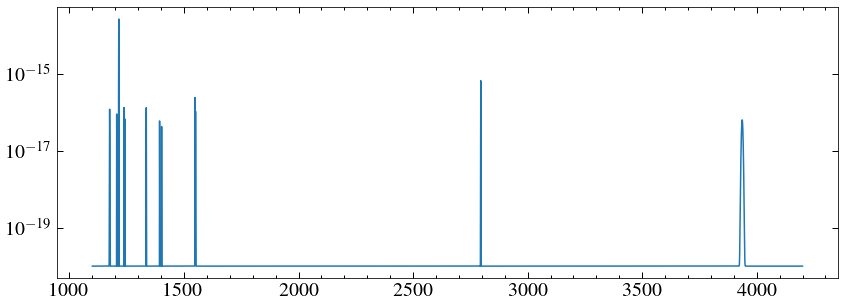

In [5]:
#put the model lines in one box

params = Table.read('emmision_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s = a[mask], m[mask], s[mask]
a += -1*o
for i in range(len(a)):
    if i == 0:
        lines_mod = models.Gaussian1D(a[i], m[i], s[i])
    else:
        lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])
#seperate ciii1176 lines
params = Table.read('ciii1176_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s, o = a[mask], m[mask], s[mask], o[mask]
a += -1*o

for i in range(len(a)):
    lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])
params = Table.read('ca_emmision_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s, o = a[mask], m[mask], s[mask], o[mask]
a += -1*o

#for i in range(len(a)):
lines_mod = lines_mod + models.Gaussian1D(a[0], m[0], s[0]) #2nd line is an upper limit
mw = np.arange(1100, 4200, 0.01)
#plt.plot(mw, lines_mod(mw))
mf = lines_mod(mw)

lya = Table.read('../lya/Trappist-1_lya_simple.txt', format='ascii')
#plt.plot(lya['WAVELENGTH'], lya['FLUX'])
lyaw, lyaf = lya['WAVELENGTH'][lya['FLUX'] > 0], lya['FLUX'][lya['FLUX'] > 0] 
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(mw)

mf += lya_f_new

plt.plot(mw, mf+1e-20)
plt.yscale('log')

In [6]:
pmod = Table.read('../optical/lyon_phoenix_2628_5.21_100um.ecsv')
pw, pf = pmod['WAVELENGTH'], pmod['FLUX']*4.67506360740083e-20

In [7]:
hdul = fits.open('../dem/spectrum_trappist_one_d13.fits')
data = hdul[1].data
dw, df, bin_el, bin_eu = data['Wavelength'], data['Flux_density'], data['Lower_Error_16'], data['Upper_Error_84']

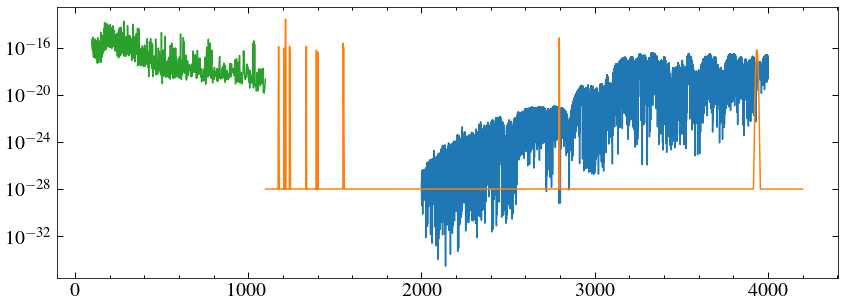

In [8]:
pcut = 4000
plt.plot(pw[(pw > dw[-1]) & (pw < pcut)], pf[(pw > dw[-1]) & (pw < pcut)])
plt.plot(mw, mf+1e-28)
plt.plot(dw[(dw >100) & (dw < 1100)], df[(dw>100) & (dw < 1100)])
plt.yscale('log')

In [9]:
sdata = fits.getdata('../combined/odlm41010_sx1.fits',1)[0]
wo, fo, eo = sdata['WAVELENGTH'], sdata['FLUX'], sdata['ERROR']

cut = 3871. #cut from error clipint

mask = (wo > cut) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
ow, of, oe = wo[mask], fo[mask], eo[mask]
mask = (of >0)
ow, of, oe = ow[mask], of[mask], oe[mask]


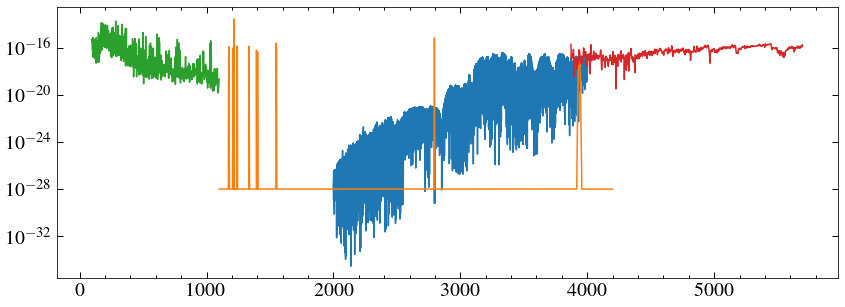

In [10]:
pcut = 4000
plt.plot(pw[(pw > dw[-1]) & (pw < pcut)], pf[(pw > dw[-1]) & (pw < pcut)])
plt.plot(mw, mf+1e-28)
plt.plot(dw[(dw >100) & (dw < 1100)], df[(dw>100) & (dw < 1100)])
plt.plot(ow, of)
plt.yscale('log')

 [astropy.modeling.fitting]


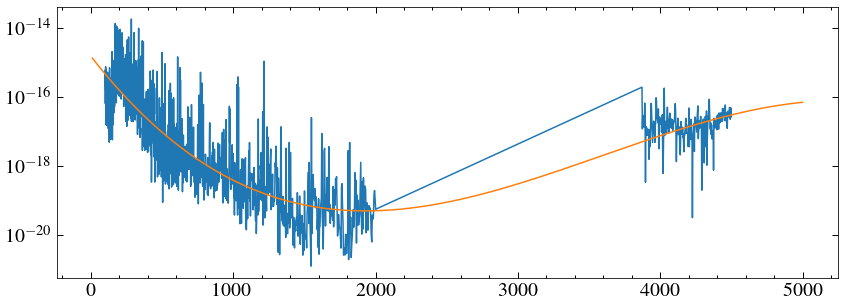

In [11]:
fitter = fitting.LinearLSQFitter()
mask1 = (dw > 100) #& (dw < 1100) 
mask2 = (ow < 4500)

#nfit = fitter(n_init, w[mask],np.log10(f[mask]))

w2fit, f2fit = np.concatenate((dw[mask1], ow[mask2])), np.concatenate((df[mask1], of[mask2]))
#w2fit, f2fit = resample.bintogrid(w2fit, f2fit, dx=1)
#w11,  f11 = resample.bintogrid(w[mask1], f[mask1], dx=1)
#w21, f21 = resample.bintogrid(wclean[mask2], fsub[mask2], dx=1)
#w2fit, f2fit = np.concatenate((w11, w21)), np.concatenate((f11, f21))

#plt.plot(w2fit, f2fit)
#plt.yscale('log')
n_init = models.Polynomial1D(4)# + models.Polynomial1D(3)
nfit = fitter(n_init, w2fit,np.log10(f2fit))
#nfit = fitter(n_init, wclean[mask2],np.log10(fsub[mask2]))
plt.plot(w2fit, f2fit)
wtest = np.arange(10, 5000, 0.1)
plt.plot(wtest, 10**nfit(wtest))
plt.yscale('log')
#nfit
#plt.xlim(3000, 4500)
#plt.ylim(1e-17, 1e-16)

 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


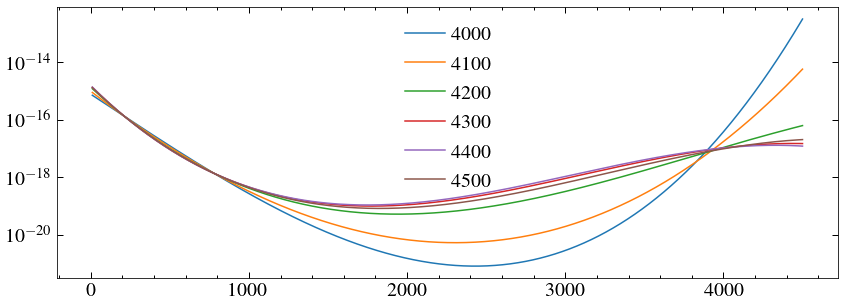

In [12]:
#for cut in (1000, 1100, 1200, 1300, 1400, 1500): 
#for cut in (4000, 4500, 5000, 5500):
for cut in (4000, 4100, 4200, 4300, 4400, 4500):
    mask1 = (dw > 100) & (dw < 1100) 
    mask2 = (ow < cut)
    w2fit, f2fit = np.concatenate((dw[mask1], ow[mask2])), np.concatenate((df[mask1], of[mask2]))

    n_init = models.Polynomial1D(4)# + models.Polynomial1D(3)
    testfit = fitter(n_init, w2fit,np.log10(f2fit))
    #plt.plot(w2fit, f2fit)
    wtest = np.arange(10, 4500, 0.1)
    plt.plot(wtest, 10**testfit(wtest), label=cut)
plt.yscale('log')
plt.legend()

Ok so the fit is fine at whatever wavelength DEM, use the FUV cutoff (1100 \AA).Optical end is the same for cuts > 4300

In [13]:
#plt.plot(ow, of)
#see if there's a natural cut off point, 4500 seems pretty good.

In [14]:
#plt.plot(ow[1:], np.diff(of))

Add Phoenix model to model bit. Where does the curve go above the model?

(1e-20, 1.732432370287227e-09)

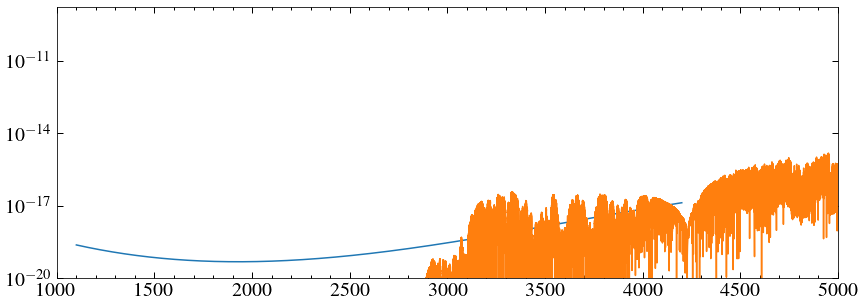

In [15]:
plt.plot(mw, 10**nfit(mw))
plt.yscale('log')
plt.plot(pw, pf)
plt.xlim(1000, 5000)
plt.ylim(1e-20)

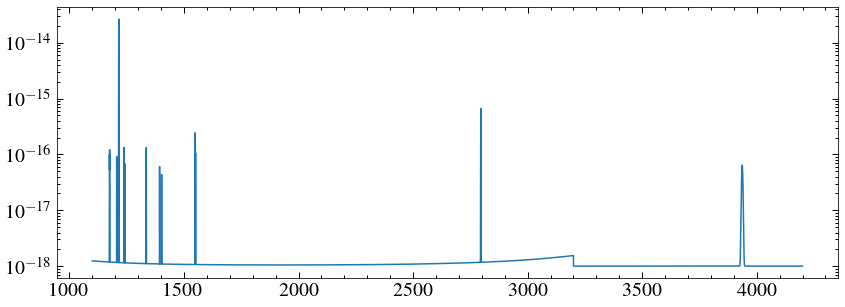

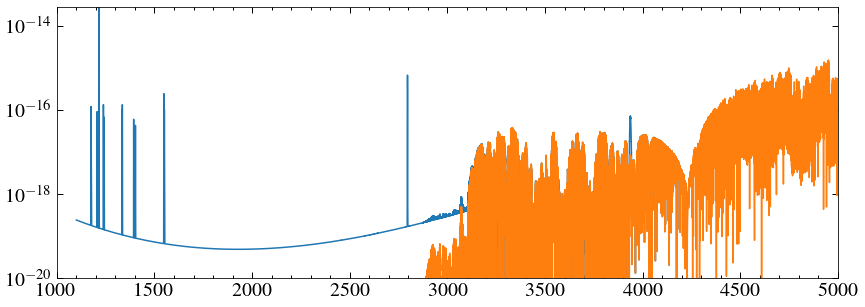

In [16]:
curve = 10**nfit(mw)
for i in range(len(curve)):
    if mw[i] > 3200:
        curve[i] = 0
mf2 = mf + curve
plt.plot(mw, mf2+1e-18)
plt.yscale('log')
plt.show()
pwadd, pfadd = pw[(pw >= mw[0]) & (pw <= mw[-1])], pf[(pw >= mw[0]) & (pw <= mw[-1])]
pwadd, pfadd = resample.bintogrid(pwadd, pfadd, newx=mw)
pfadd = np.insert(pfadd, 0, pfadd[0])
#for i in range(len(pfadd))
mf3 = mf2 + pfadd 
plt.plot(mw, mf3)
plt.plot(pw, pf, )
plt.xlim(1000, 5000)
plt.ylim(1e-20)
plt.yscale('log')
plt.show()


In [17]:
#grab the apec model
apec = fits.getdata('../xmm/Trappist-1.fits',2)
#plt.plot(apec['Wave'], apec['FLUX'])
aw, af = apec['Wave'], apec['FLUX']

Pulling it all together...

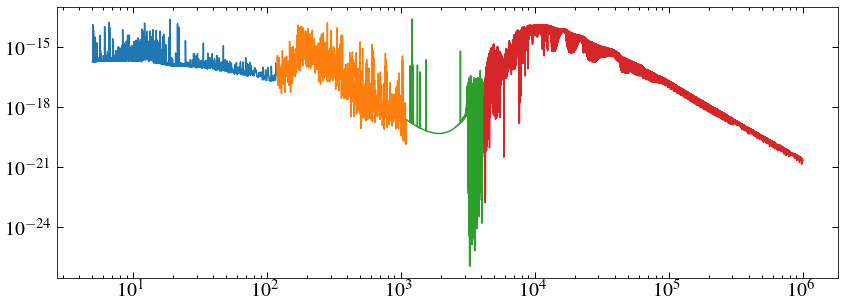

In [18]:
#plt.plot(mw, mf3)
plt.plot(aw, af)
plt.plot(dw[(dw >aw[-1]) & (dw < 1100)], df[(dw >aw[-1]) & (dw < 1100)])
plt.plot(mw, mf3)
plt.plot(pw[(pw > 4200)], pf[(pw > 4200)])

plt.yscale('log')
plt.xscale('log')

In [19]:
def dem_to_1A(w,f):
    """
    Converts a DEM model at 5A resolution to 1A resolution
    """
    w1 = np.arange(w[0], w[-1], 1.)
    f1 = interp1d(w, f, fill_value='extrapolate', kind='nearest')(w1)
    return w1, f1

In [20]:
dw1, df1 = dw[(dw >aw[-1]) & (dw < 1100)], df[(dw >aw[-1]) & (dw < 1100)]
dw1, df1 = dem_to_1A(dw1, df1)

In [21]:
pw1, pf1 = pw[(pw > 4200)], pf[(pw > 4200)]

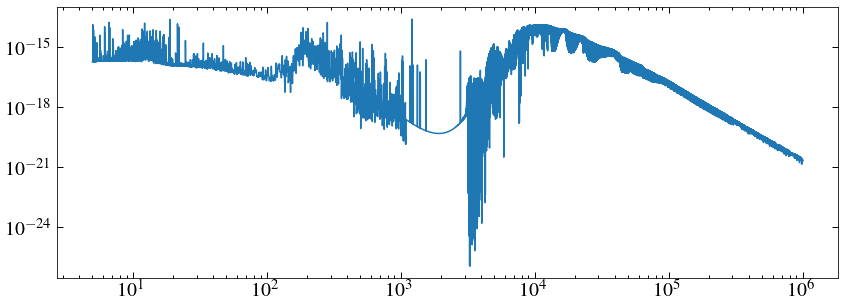

In [22]:
model_w = np.concatenate((aw, dw1, mw, pw1))
model_f = np.concatenate((af, df1, mf3, pf1))
plt.plot(model_w, model_f)

plt.xscale('log')
plt.yscale('log')

In [23]:
model_w_1A, model_f_1A = resample.bintogrid(model_w, model_f, dx=1)

In [24]:
savdat = Table([model_w, model_f], names=['WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'saved_models/trappist-1_model_var_res_v07.ecsv', format='ecsv', overwrite=True)
savdat = Table([model_w_1A, model_f_1A], names=['WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'saved_models/trappist-1_model_const_res_v07.ecsv', format='ecsv', overwrite=True)

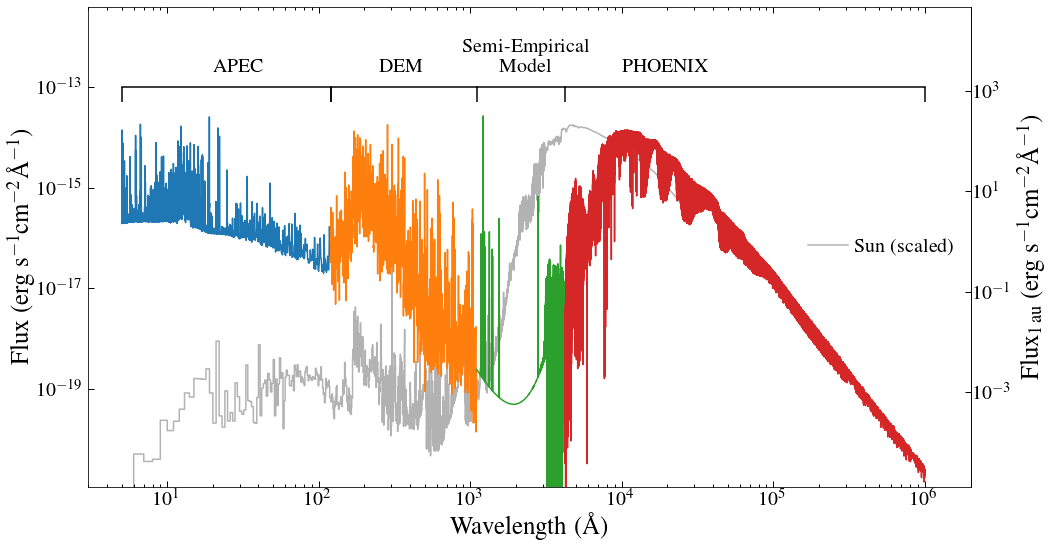

In [25]:
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from matplotlib.transforms import Transform

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(aw, af)
plt.plot(dw[(dw >aw[-1]) & (dw < 1100)], df[(dw >aw[-1]) & (dw < 1100)])
plt.plot(mw, mf3)
plt.plot(pw[(pw > 4200)], pf[(pw > 4200)])

#plt.step(w,f/5, zorder=-5, c='0.5', where='mid')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(90, 10000)
#plt.errorbar((15,60),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
#plt.annotate('XMM', (20, 2e-13))



plt.errorbar((5,120),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('APEC', (20, 2e-13))

plt.errorbar((120,1100),(1e-13, 1e-13), yerr= [[5e-14,0],[0,0]], c ='k')
plt.annotate('DEM', (250, 2e-13))

plt.errorbar((1100, 4200),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('Semi-Empirical\n Model', (2300, 2e-13), ha='center')

plt.errorbar((4200, 1000000),(1e-13, 1e-13), yerr= [[0,5e-14],[0,0]], c ='k')
plt.annotate('PHOENIX', (10000, 2e-13))

sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = (u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2
plt.step(w_sol[w_sol>5], f_sol[w_sol>5]/bb_scale, zorder=-100, c='k', label = 'Sun (scaled)' , where='mid', alpha=0.3)

plt.ylim(1.1e-21, 3.9e-12)
plt.xlim(3, 2e6)
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.legend(loc=5)

def t_to_s(x):
    return x*bb_scale.value

def s_to_t(x):
    return x/bb_scale.value

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False)      # ticks along the bottom edge are off   
secay = ax.secondary_yaxis('right', functions =(t_to_s, s_to_t))
#secay.yaxis.set_minor_locator(AutoMinorLocator())
secay.set_ylabel('Flux$_{\mathrm{ 1\,au}}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size =25)


plt.tight_layout()
#plt.savefig('../plots/SEmp_v_sun.png', dpi= 150)
plt.savefig('../plots/new_SEmp_v_sun.pdf', dpi= 150)

Making a plot comparing Earth flux to Trappist 1e

7285615883927298.0


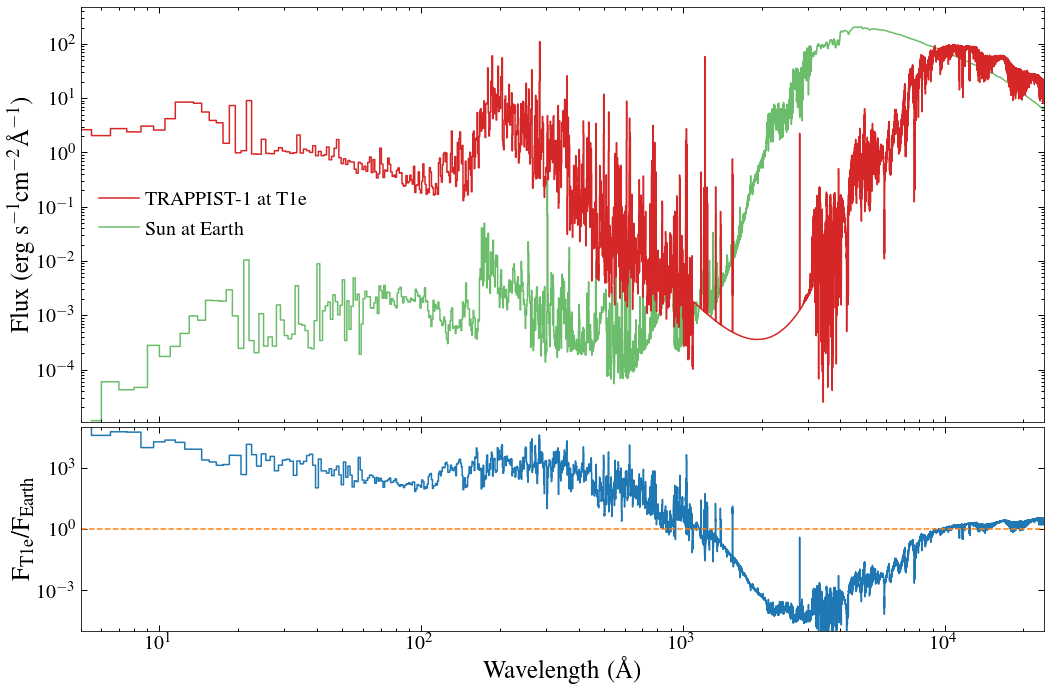

In [107]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(6, 1, figure=fig)


a_t1e = 29.24e-3*u.au #au
t1escale = (d_t1.to(u.au)/a_t1e)**2
print(t1escale)
plt.subplot(gs[:4])
plt.step(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]]*t1escale, where='mid', c='C3', label = 'TRAPPIST-1 at T1e')
plt.xscale('log')
plt.yscale('log')
plt.step(w_sol[w_sol>=model_w_1A[0]], f_sol[w_sol>model_w_1A[0]], zorder=-100, c='C2', label = 'Sun at Earth' , where='mid', alpha=0.7)
plt.ylim(1.1e-5)
plt.legend(loc=6)
plt.xlim(model_w_1A[0], w_sol[-1])

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.xticks(visible=False)


plt.subplot(gs[4:])
modwi, modfi = resample.bintogrid(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]], newx =w_sol[w_sol>=model_w[0]]) 
plt.step(modwi, (modfi*t1escale)/f_sol[w_sol>model_w[0]])
plt.xscale('log')
plt.yscale('log')
plt.axhline(1, ls ='--', c='C1')
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('F$_{\mathrm{T1e}}$/F$_{\mathrm{Earth}}$', size=25)
plt.xlim(model_w_1A[0], w_sol[-1])
plt.ylim(9.9e-6, 1.1e5)
#plt.yticks((1e-4, 1e-2, 1, 100, 10000))#, ('0.0001', '0.01', '1', '100', '10000'))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('../plots/t1e_v_earth_ratio.pdf')

7285615883927298.0


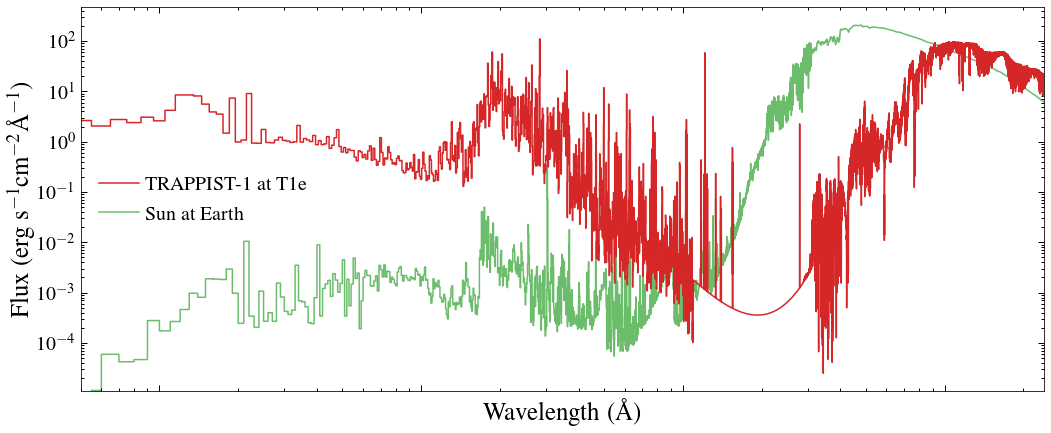

In [106]:
fig = plt.figure(figsize=(15, 9))


a_t1e = 29.24e-3*u.au #au
t1escale = (d_t1.to(u.au)/a_t1e)**2
print(t1escale)
plt.subplot(gs[:4])
plt.step(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]]*t1escale, where='mid', c='C3', label = 'TRAPPIST-1 at T1e')
plt.xscale('log')
plt.yscale('log')
plt.step(w_sol[w_sol>=model_w_1A[0]], f_sol[w_sol>model_w_1A[0]], zorder=-100, c='C2', label = 'Sun at Earth' , where='mid', alpha=0.7)
plt.ylim(1.1e-5)
plt.legend(loc=6)
plt.xlim(model_w_1A[0], w_sol[-1])

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.xticks(visible=False)
plt.xlabel('Wavelength (\AA)', size=25)
plt.tight_layout()
plt.savefig('../plots/t1e_v_earth_no_ratio.pdf')

And the young sun? Using stuff LK sent me.

In [109]:
yspath = '/home/david/work/muscles/sun/forDavidTrappist1/'
ysdats = glob.glob('{}*.dat'.format(yspath))
ysdats

['/home/david/work/muscles/sun/forDavidTrappist1/Formation_4.55Ga_at_1.00AU copy.dat',
 '/home/david/work/muscles/sun/forDavidTrappist1/Epoch_0.00Ga_at_1.00AU.dat',
 '/home/david/work/muscles/sun/forDavidTrappist1/Epoch0_3.90Ga_at_1.00AU.dat']

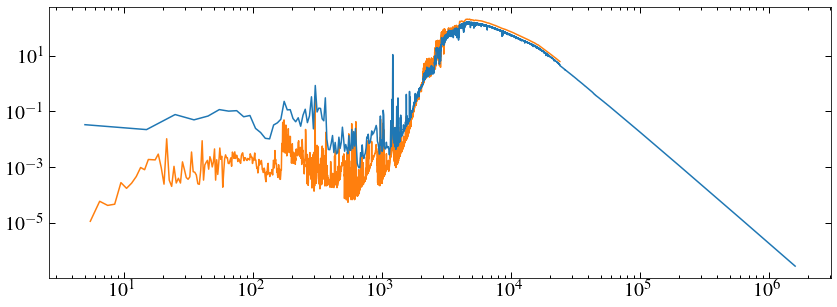

In [117]:
ysw, ysf = np.loadtxt(ysdats[2], skiprows=1, unpack=True)
plt.plot(ysw, ysf)
plt.xscale('log')
plt.yscale('log')
plt.plot(w_sol[w_sol>ysw[0]], f_sol[w_sol>ysw[0]], zorder=-1)

7285615883927298.0
26486 26486 26489


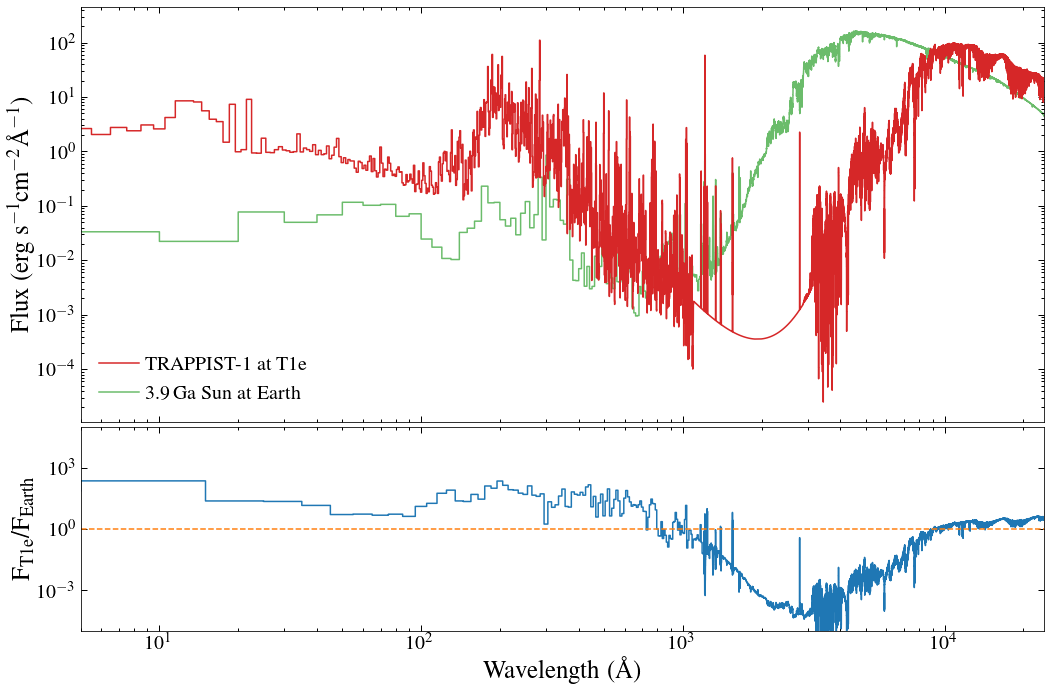

In [135]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(6, 1, figure=fig)


a_t1e = 29.24e-3*u.au #au
t1escale = (d_t1.to(u.au)/a_t1e)**2
print(t1escale)
plt.subplot(gs[:4])
plt.step(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]]*t1escale, where='mid', c='C3', label = 'TRAPPIST-1 at T1e')
plt.xscale('log')
plt.yscale('log')
plt.step(ysw[ysw>=model_w_1A[0]], ysf[ysw>=model_w_1A[0]], zorder=-100, c='C2', label = '3.9\,Ga Sun at Earth' , where='mid', alpha=0.7)
plt.ylim(1.1e-5)
plt.legend(loc=3)
plt.xlim(model_w_1A[0], w_sol[-1])

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.xticks(visible=False)


plt.subplot(gs[4:])
modwi, modfi = resample.bintogrid(model_w_1A[(model_w_1A >=ysw[0]) & (model_w_1A <=ysw[-1])], model_f_1A[(model_w_1A >=ysw[0]) & (model_w_1A <=ysw[-1])], newx =ysw)#[ysw>=model_w[0]]) 
print(len(modwi), len(modfi), len(ysw))
plt.step(modwi, (modfi*t1escale)/ysf[:-3])#[ysw>=model_w[0]])
plt.xscale('log')
plt.yscale('log')
plt.axhline(1, ls ='--', c='C1')
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('F$_{\mathrm{T1e}}$/F$_{\mathrm{Earth}}$', size=25)
plt.xlim(model_w_1A[0], w_sol[-1])
plt.ylim(9.9e-6, 1.1e5)
#plt.yticks((1e-4, 1e-2, 1, 100, 10000))#, ('0.0001', '0.01', '1', '100', '10000'))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('../plots/t1e_v_earth_young_sun_ratio.pdf')

7285615883927298.0


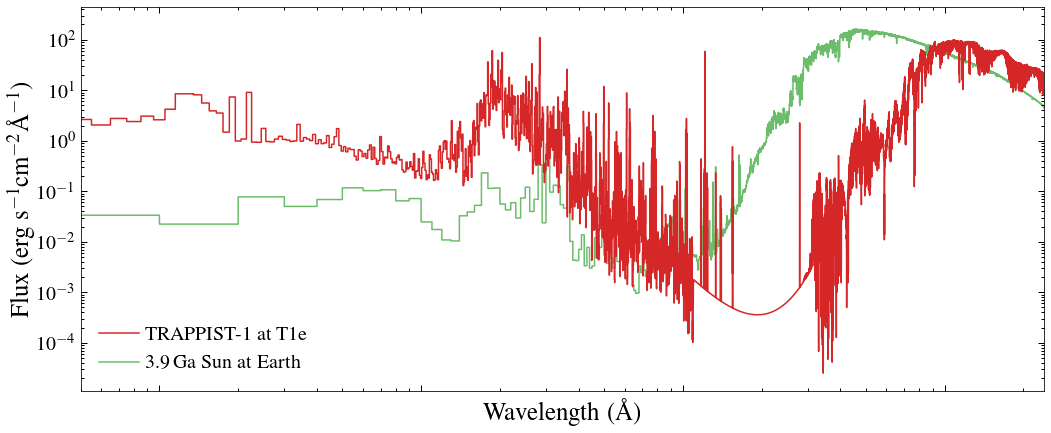

In [139]:
fig = plt.figure(figsize=(15, 9))


a_t1e = 29.24e-3*u.au #au
t1escale = (d_t1.to(u.au)/a_t1e)**2
print(t1escale)
plt.subplot(gs[:4])
plt.step(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]]*t1escale, where='mid', c='C3', label = 'TRAPPIST-1 at T1e')
plt.xscale('log')
plt.yscale('log')
plt.step(ysw[ysw>=model_w_1A[0]], ysf[ysw>=model_w_1A[0]], zorder=-100, c='C2', label = '3.9\,Ga Sun at Earth' , where='mid', alpha=0.7)
plt.ylim(1.1e-5)
plt.legend(loc=3)
plt.xlim(model_w_1A[0], w_sol[-1])

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.xticks(visible=False)
plt.xlabel('Wavelength (\AA)', size=25)
plt.tight_layout()
plt.savefig('../plots/t1e_v_earth_young_sun_no_ratio.pdf')

And AD Leo..at 1au? T-1e?

In [148]:
adleo = Table.read('../../../ad_leo/ad_leo_sed_v1_1A.ecsv')


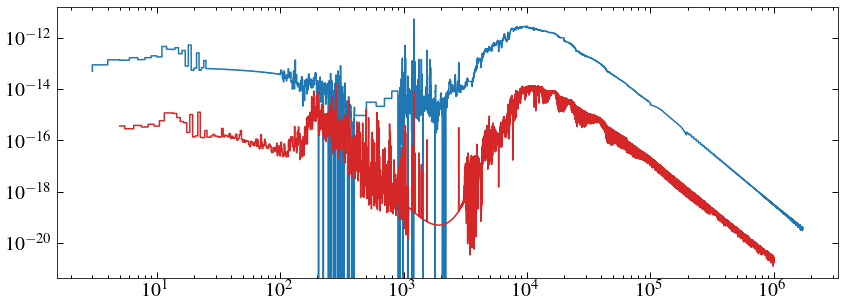

In [149]:
plt.step(adw, adf)
plt.step(model_w_1A, model_f_1A, where='mid', c='C3', label = 'TRAPPIST-1 at T1e')
plt.yscale('log')
plt.xscale('log')

In [147]:
adleo_d = 1/(201.36831861385065e-3)*u.pc

In [156]:
adw, adf = adleo['WAVELENGTH'], adleo['FLUX']
admask = (adw >=model_w_1A[0]) & (adw <= model_w_1A[-1]) & (adf >0)
adw, adf = adw[admask], adf[admask]

In [169]:
t1au = ((d_t1.to(u.au))/(1*u.au))**2
ad1au = ((adleo_d.to(u.au))/(1*u.au))**2

tadl =3390*u.K
radl = 0.39*u.Rsun

adl_bb_scale = (radl**2 * tadl**4)/(r_t1**2 * t_t1**4)*(d_t1/adleo_d)**2


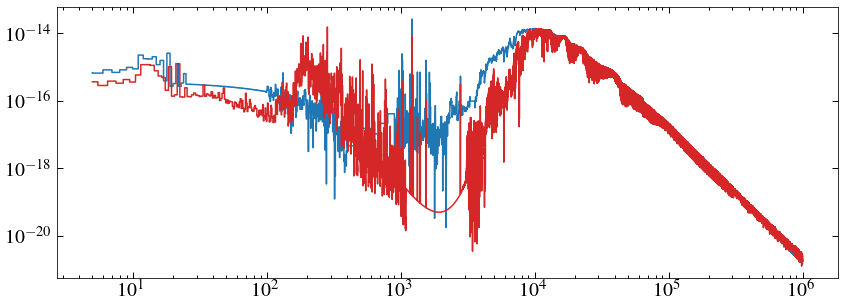

In [171]:
plt.step(adw, adf/adl_bb_scale)
plt.step(model_w_1A, model_f_1A, where='mid', c='C3', label = 'TRAPPIST-1 at T1e')
plt.yscale('log')
plt.xscale('log')

7285615883927298.0
999893 999893 999898


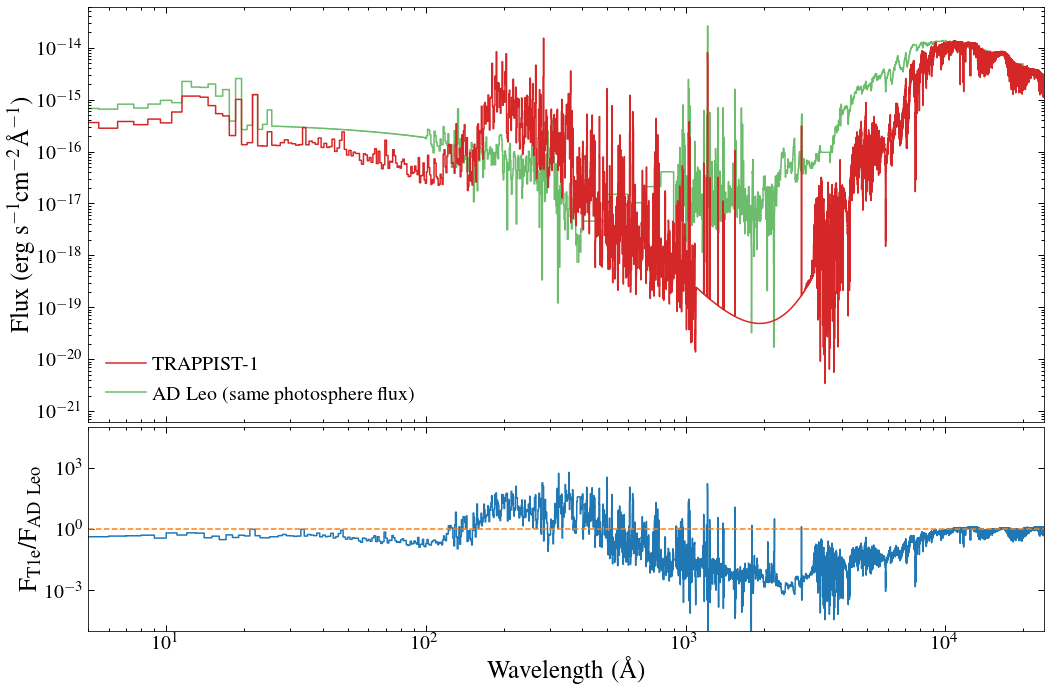

In [192]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(6, 1, figure=fig)


a_t1e = 29.24e-3*u.au #au
t1escale = (d_t1.to(u.au)/a_t1e)**2
print(t1escale)
plt.subplot(gs[:4])
plt.step(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]], where='mid', c='C3', label = 'TRAPPIST-1')
plt.xscale('log')
plt.yscale('log')
plt.step(adw, adf/adl_bb_scale, zorder=-100, c='C2', label = 'AD Leo (same photosphere flux)' , where='mid', alpha=0.7)
#plt.ylim(1.1e-5)
plt.legend(loc=3)
plt.xlim(model_w_1A[0], w_sol[-1])

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.xticks(visible=False)


plt.subplot(gs[4:])
modwi, modfi = resample.bintogrid(model_w_1A[(model_w_1A >=adw[0]) & (model_w_1A <=adw[-1])], model_f_1A[(model_w_1A >=adw[0]) & (model_w_1A <=adw[-1])], newx =adw)#[ysw>=model_w[0]]) 
print(len(modwi), len(modfi), len(adw))
plt.step(modwi, (modfi)/(adf/adl_bb_scale)[:-5])
plt.xscale('log')
plt.yscale('log')
plt.axhline(1, ls ='--', c='C1')
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('F$_{\mathrm{T1e}}$/F$_{\mathrm{AD\ Leo}}$', size=25)
plt.xlim(model_w_1A[0], w_sol[-1])
plt.ylim(9.9e-6, 1.1e5)
#plt.yticks((1e-4, 1e-2, 1, 100, 10000))#, ('0.0001', '0.01', '1', '100', '10000'))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('../plots/t1_v_ad_leo_ratio.pdf')

7285615883927298.0


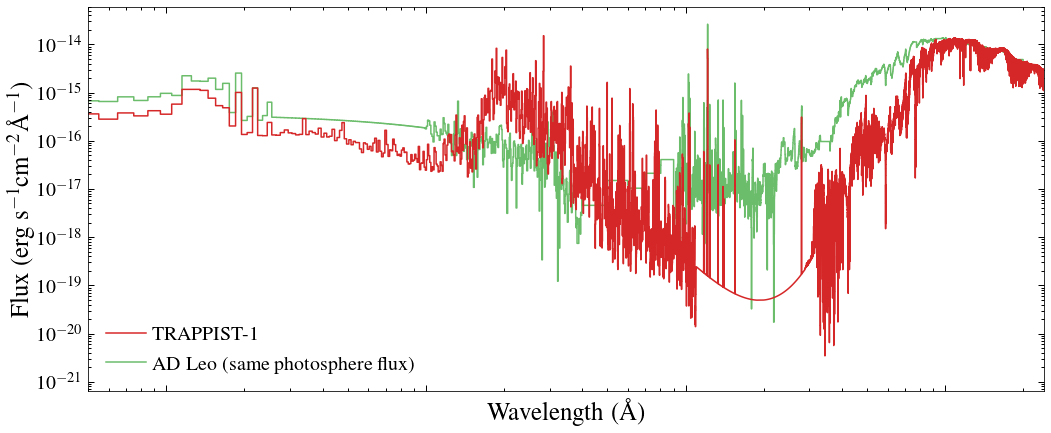

In [185]:
fig = plt.figure(figsize=(15, 9))


a_t1e = 29.24e-3*u.au #au
t1escale = (d_t1.to(u.au)/a_t1e)**2
print(t1escale)
plt.subplot(gs[:4])
plt.step(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]], where='mid', c='C3', label = 'TRAPPIST-1')
plt.xscale('log')
plt.yscale('log')
plt.step(adw, adf/adl_bb_scale, zorder=-100, c='C2', label = 'AD Leo (same photosphere flux)' , where='mid', alpha=0.7)
#plt.ylim(1.1e-5)
plt.legend(loc=3)
plt.xlim(model_w_1A[0], w_sol[-1])

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.xticks(visible=False)
plt.xlabel('Wavelength (\AA)', size=25)
plt.tight_layout()
plt.savefig('../plots/t1e_v_ad_leo_no_ratio.pdf')

All the ratios...

26486 26486 26489
999893 999893 999898


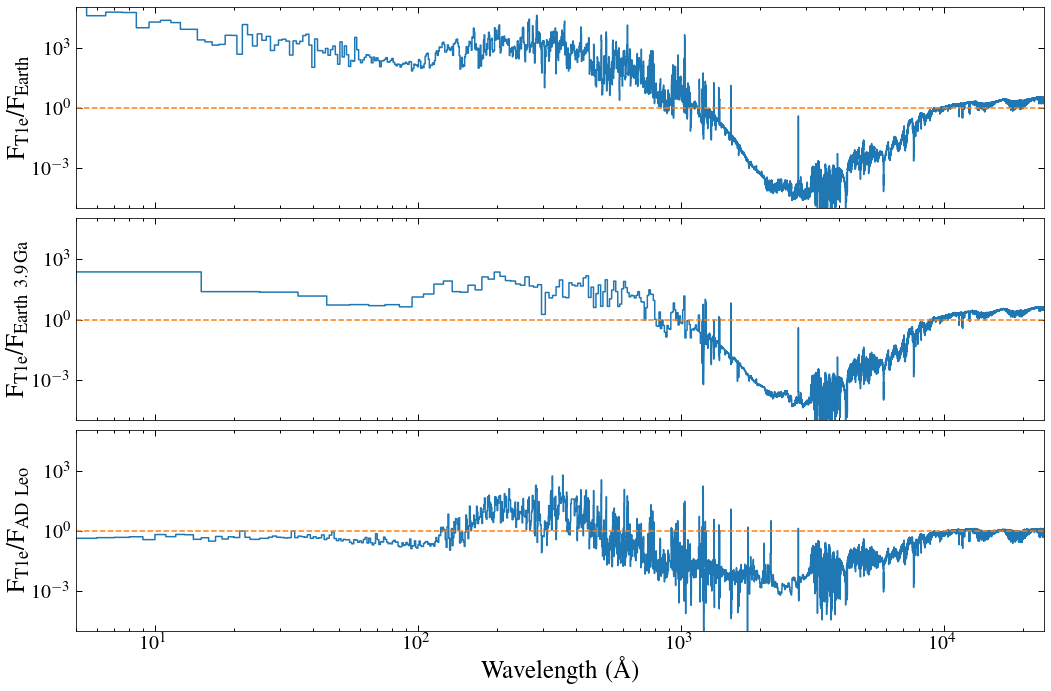

In [197]:
plt.figure(figsize=(15,10))


plt.subplot(311)
modwi, modfi = resample.bintogrid(model_w_1A[model_w_1A <=w_sol[-1]], model_f_1A[model_w_1A <=w_sol[-1]], newx =w_sol[w_sol>=model_w[0]]) 
plt.step(modwi, (modfi*t1escale)/f_sol[w_sol>model_w[0]])
plt.xscale('log')
plt.yscale('log')
plt.axhline(1, ls ='--', c='C1')
plt.xticks(visible=False)
plt.ylabel('F$_{\mathrm{T1e}}$/F$_{\mathrm{Earth}}$', size=25)
plt.xlim(model_w_1A[0], w_sol[-1])
plt.ylim(9.9e-6, 1.1e5)


plt.subplot(312)
modwi, modfi = resample.bintogrid(model_w_1A[(model_w_1A >=ysw[0]) & (model_w_1A <=ysw[-1])], model_f_1A[(model_w_1A >=ysw[0]) & (model_w_1A <=ysw[-1])], newx =ysw)#[ysw>=model_w[0]]) 
print(len(modwi), len(modfi), len(ysw))
plt.step(modwi, (modfi*t1escale)/ysf[:-3])#[ysw>=model_w[0]])
plt.xscale('log')
plt.yscale('log')
plt.axhline(1, ls ='--', c='C1')
plt.xticks(visible=False)
plt.ylabel('F$_{\mathrm{T1e}}$/F$_{\mathrm{Earth\ 3.9\,Ga}}$', size=25)
plt.xlim(model_w_1A[0], w_sol[-1])
plt.ylim(9.9e-6, 1.1e5)

                    
plt.subplot(313)
modwi, modfi = resample.bintogrid(model_w_1A[(model_w_1A >=adw[0]) & (model_w_1A <=adw[-1])], model_f_1A[(model_w_1A >=adw[0]) & (model_w_1A <=adw[-1])], newx =adw)#[ysw>=model_w[0]]) 
print(len(modwi), len(modfi), len(adw))
plt.step(modwi, (modfi)/(adf/adl_bb_scale)[:-5])
plt.xscale('log')
plt.yscale('log')
plt.axhline(1, ls ='--', c='C1')
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('F$_{\mathrm{T1e}}$/F$_{\mathrm{AD\ Leo}}$', size=25)
plt.xlim(model_w_1A[0], w_sol[-1])
plt.ylim(9.9e-6, 1.1e5)
#plt.yticks((1e-4, 1e-2, 1, 100, 10000))#, ('0.0001', '0.01', '1', '100', '10000'))
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('../plots/t1_ratios.pdf')